# Apprentissage pour la détection de masque

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import cv2
import os, sys
from google.colab import drive
import tensorflow as tf
import keras
from keras.layers import Dense, Flatten, Resizing, Rescaling, RandomFlip, RandomRotation
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Partie 1: Base de données, analyse et préparation

In [2]:
# import des images
directory = '/content/drive/My Drive/Mask_Data/'

images = []
labels = []

for i in os.listdir(directory):
    Path = directory+"/"+i
    
    for j in os.listdir(Path):
        image = cv2.imread(Path+"/"+j)
        image = cv2.resize(image, (224,224))
        images.append(image)
        if i == 'without_mask':
            labels.append(0)
        else:
            labels.append(1)
        #labels.append(str(i))

# transformer les listes en np.array      
images = np.array(images)   
labels = np.array(labels)

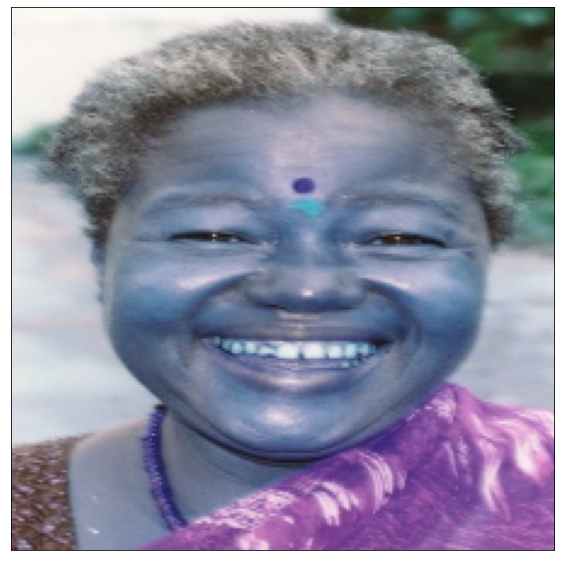

In [3]:
# Visualiser une image au hasard
plt.figure(figsize=(10,10))
waiwai = np.random.randint(0,1000,[1])
plt.subplot()
plt.xticks([])
plt.yticks([])
plt.imshow(images[waiwai[0]])
plt.show()

In [4]:
# préparer un jeu de validation
X, X_val, y, y_val = train_test_split(images, labels, test_size = 0.1, stratify=labels, random_state = 0)

# préparer un jeu de test et de train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 0)

#### Partie 2 Architecture CNN sur tensorflow

In [5]:
# générer les paramètres de l'augmentation
augmentation = ImageDataGenerator(
        rotation_range = 10,
        fill_mode="nearest",
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )


# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False



# initialisation du modèle
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

58900480/58889256 [==============================] - 1s 0us/step


In [6]:
# convertir les labels en matrices binaires
y_train = tf.keras.utils.to_categorical(y_train, 2) 
y_test = tf.keras.utils.to_categorical(y_test, 2)


# compiler le modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


# fonction callback pour sauvegarde du modèle
filepath = "/home"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_model_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# arrêter entraînement si bon modèle
stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# entraînement du modèle
history = model.fit(
	augmentation.flow(X_train, y_train),
	validation_data=(X_test, y_test),
	epochs=20,
  callbacks=[model_checkpoint_callback, stop])

Epoch 1/20
34/34 [==============================] - 50s 1s/step - loss: 10.3055 - accuracy: 0.8396 - val_loss: 0.4321 - val_accuracy: 0.9890
Epoch 2/20
34/34 [==============================] - 21s 611ms/step - loss: 0.4045 - accuracy: 0.8912 - val_loss: 0.0316 - val_accuracy: 0.9890
Epoch 3/20
34/34 [==============================] - 21s 610ms/step - loss: 0.2362 - accuracy: 0.9171 - val_loss: 0.0381 - val_accuracy: 0.9890
Epoch 4/20
34/34 [==============================] - 21s 611ms/step - loss: 0.2173 - accuracy: 0.9152 - val_loss: 0.0565 - val_accuracy: 0.9853
Epoch 5/20
34/34 [==============================] - 30s 874ms/step - loss: 0.1974 - accuracy: 0.9309 - val_loss: 0.0183 - val_accuracy: 0.9926
Epoch 6/20
34/34 [==============================] - 30s 875ms/step - loss: 0.1776 - accuracy: 0.9290 - val_loss: 0.0188 - val_accuracy: 0.9963
Epoch 7/20
34/34 [==============================] - 19s 551ms/step - loss: 0.1444 - accuracy: 0.9429 - val_loss: 0.0339 - val_accuracy: 0.9926
E

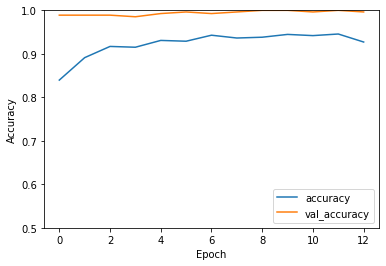

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Sauvegarder le modèle
model.save('/home/mod.h5')

In [8]:
# effectuer les prédictions sur les données de validation
y_pred = np.argmax(model.predict(X_val), axis=-1)


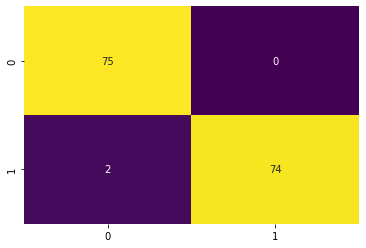

In [ ]:
# Afficher la matrice de confusion sur les données de validation
seaborn.heatmap(confusion_matrix(y_val, y_pred), annot=True,cmap='viridis', cbar=False)


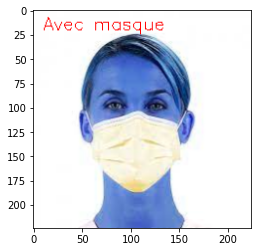

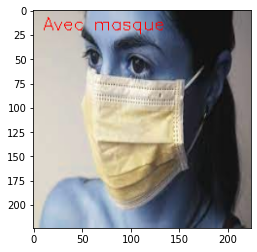

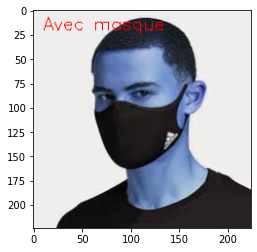

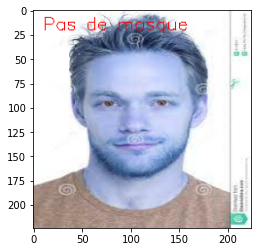

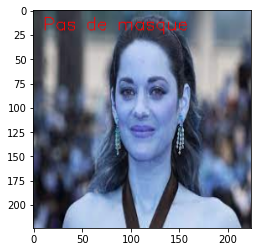

In [10]:
# effectuer quelques essais avec des photos
path_photos = '/content/drive/My Drive/Colab Notebooks/photos'


for photo in os.listdir(path_photos):


  path = os.path.join(path_photos, photo)
  
  OK = cv2.imread(path)
  OK = cv2.resize(OK, (224,224))
  ok = OK.copy()
  OK = np.expand_dims(OK,axis=0)

  print("=================================================")

  if np.argmax(model.predict(OK)) < 0.5:
    phrase = "Pas de masque"
  elif np.argmax(model.predict(OK)) > 0.5:
    phrase = "Avec masque"
  else:
    phrase = "kif kif"


  # print(phrase)
  plt.figure()
  cv2.putText(ok, phrase, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0))
  plt.imshow(ok)
  
  plt.show()
  print("=================================================")